In [1]:
import os
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as tf_text
from sklearn.model_selection import train_test_split

2024-02-29 11:06:58.728543: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 11:06:58.980419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 11:06:58.980547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 11:06:59.002248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 11:06:59.068491: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 11:06:59.070915: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def get_data(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    lines = [line.split('\t') for line in lines]
    context = np.array([context for _, context, _ in lines]) 
    target = np.array([target for target, _, _ in lines])
    return context, target

In [3]:
filepath = Path("datasets/Languages/heb.txt")
raw_context, raw_target = get_data(filepath)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(raw_context, raw_target, test_size=0.2)

In [5]:
BATCH_SIZE = 64
SHUFFLE_SIZE = len(raw_context)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

2024-02-29 11:07:04.401499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-29 11:07:04.602064: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
def tf_lower_punct_normalize(text):
    text = tf_text.normalize_utf8(text, "NFKD")
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-zא-ת.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text
    

In [8]:
context_text_processor = keras.layers.TextVectorization(max_tokens=15000 ,standardize=tf_lower_punct_normalize, ragged=True)
target_text_processor = keras.layers.TextVectorization(max_tokens=10000, standardize=tf_lower_punct_normalize, ragged=True)

In [9]:
context_text_processor.adapt(train_dataset.map(lambda context, target: context))
target_text_processor.adapt(train_dataset.map(lambda context, target: target))

In [10]:
context_vocab = context_text_processor.get_vocabulary()
target_vocab = target_text_processor.get_vocabulary()

In [11]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()

    target = target_text_processor(target)
    target_in = target[:, :-1].to_tensor()
    target = target[:, 1:].to_tensor()
    
    return (context, target_in), target

In [12]:
train_dataset = train_dataset.map(process_text, tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_text, tf.data.AUTOTUNE)

In [13]:
for (ex_context, ex_tar_in), ex_tar_out in train_dataset.take(1):
    print(ex_context[:5])
    print(ex_tar_in[:5])
    print(ex_tar_out[:5])

tf.Tensor(
[[    2    16   553   217     8     3     0     0     0     0     0     0
      0     0     0]
 [    2    45   589    14   177  3575     8     3     0     0     0     0
      0     0     0]
 [    2    14   315   200    49     3     0     0     0     0     0     0
      0     0     0]
 [    2   130     9    24   426    54   635     4     3     0     0     0
      0     0     0]
 [    2   273  1434    32    46 12876     8     3     0     0     0     0
      0     0     0]], shape=(5, 15), dtype=int64)
tf.Tensor(
[[   2  169   95  254   11    0    0    0    0    0    0    0    0]
 [   2   50  270   20    9  181 3388   11    0    0    0    0    0]
 [   2    9   37   20   15    4    0    0    0    0    0    0    0]
 [   2  328   37  678   22 2717    4    0    0    0    0    0    0]
 [   2   86  108   32  247  718   10 6245   11    0    0    0    0]], shape=(5, 13), dtype=int64)
tf.Tensor(
[[ 169   95  254   11    3    0    0    0    0    0    0    0    0]
 [  50  270   20    9  1

In [14]:
class Encoder(keras.layers.Layer):
    def __init__(self, units, text_processor, **kwargs):
        super().__init__(**kwargs)
        
        self.units = units
        self.text_processor = text_processor
        self.vocab_size = self.text_processor.vocabulary_size()

        self.embedding_layer = keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.units)
        self.rnn = keras.layers.Bidirectional(keras.layers.GRU(self.units, 
                                                               return_sequences=True, 
                                                               recurrent_initializer='glorot_uniform'), 
                                              merge_mode="sum")
    def call(self, input):
        embedding = self.embedding_layer(input)
        context = self.rnn(embedding)
        return context

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        texts = self.text_processor(texts).to_tensor()
        context = self(texts)
        return context

In [15]:
class CrossAttention(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=256, num_heads=1, **kwargs)
        self.normalization_layer = keras.layers.LayerNormalization()
        self.add = keras.layers.Add()

    def call(self, inputs):
        context, x = inputs
        attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)        
        self.last_attention_weights = tf.reduce_mean(attn_scores, axis=-1)
        x = self.add([x, attn_output])
        x = self.normalization_layer(x)
        return x

In [16]:
class Decoder(keras.layers.Layer):
    def __init__(self, units, text_processor, **kwargs):
        super().__init__()

        self.units = units
        self.text_processor = text_processor
        self.vocab_size = self.text_processor.vocabulary_size()
        self.text_to_id = keras.layers.StringLookup(vocabulary=self.text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_text = keras.layers.StringLookup(vocabulary=self.text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
        
        self.start_token = self.text_to_id('[START]')
        self.end_token = self.text_to_id('[END]')
        
        self.embedding_layer = keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.units)
        self.rnn = keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.attention = CrossAttention()
        self.output_layer = keras.layers.Dense(self.vocab_size)
    
    def call(self, inputs, state=None, return_state=False):
        context, x_in = inputs
        
        x = self.embedding_layer(x_in)
        x, state = self.rnn(x, initial_state=state)
        
        x = self.attention((context, x))
        self.last_attention_weights = self.attention.last_attention_weights
        
        logits = self.output_layer(x)

        if return_state:
            return logits, state
        else:
            return logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedding = self.embedding_layer(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedding)[0]

    def get_next_token(self, context, tokens, done, state):
        logits, state = self((context, tokens), state, True)

        next_token = tf.argmax(logits, axis=-1)

        done = done | (next_token == self.end_token)

        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
        
        return next_token, done, state

    def tokens_to_text(self, tokens):
        words = self.id_to_text(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result

In [17]:
class Translator(keras.models.Model):
    def __init__(self, units, context_processor, target_processor, **kwargs):
        super().__init__(**kwargs)

        
        self.encoder = Encoder(units, context_processor)
        self.decoder = Decoder(units, target_processor)
        
    def call(self, inputs):
        x, y_in = inputs
        context = self.encoder(x)
        logits = self.decoder((context, y_in))
        
        return logits

    def translate(self, text):
        max_len = 50
        context = self.encoder.convert_input(text)

        tokens = []
        attention_weights = []
        
        next_tokens, done, state = self.decoder.get_initial_state(context)

        for _ in range(max_len):
            next_tokens, done, state = self.decoder.get_next_token(context, next_tokens, done, state)
            tokens.append(next_tokens)
            attention_weights.append(self.decoder.last_attention_weights)
            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        tokens = tf.concat(tokens, axis=-1)
        
        return self.decoder.tokens_to_text(tokens)

In [18]:
def masked_loss(y_true, y_pred):
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_pred == y_true, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [19]:
model = Translator(256, context_text_processor, target_text_processor)
model.compile(loss=masked_loss, optimizer='adam', metrics=[masked_acc])

In [20]:
history = model.fit(
    train_dataset.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_dataset,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 29s 251ms/step - loss: 5.3732 - masked_acc: 0.2414 - val_loss: 4.4257 - val_masked_acc: 0.3232
Epoch 2/100
100/100 [==============================] - 25s 249ms/step - loss: 4.1539 - masked_acc: 0.3507 - val_loss: 3.8491 - val_masked_acc: 0.3798
Epoch 3/100
100/100 [==============================] - 23s 234ms/step - loss: 3.6894 - masked_acc: 0.4109 - val_loss: 3.4729 - val_masked_acc: 0.4271
Epoch 4/100
100/100 [==============================] - 24s 244ms/step - loss: 3.3387 - masked_acc: 0.4556 - val_loss: 3.1390 - val_masked_acc: 0.4784
Epoch 5/100
100/100 [==============================] - 26s 258ms/step - loss: 3.0436 - masked_acc: 0.4970 - val_loss: 2.8502 - val_masked_acc: 0.5203
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 2.7911 - masked_acc: 0.5333 - val_loss: 2.6566 - val_masked_acc: 0.5378
Epoch 7/100
100/100 [==============================] - 26s 258ms/step - loss: 2.6285 - masked_acc: 0

In [21]:
import matplotlib.pyplot as plt

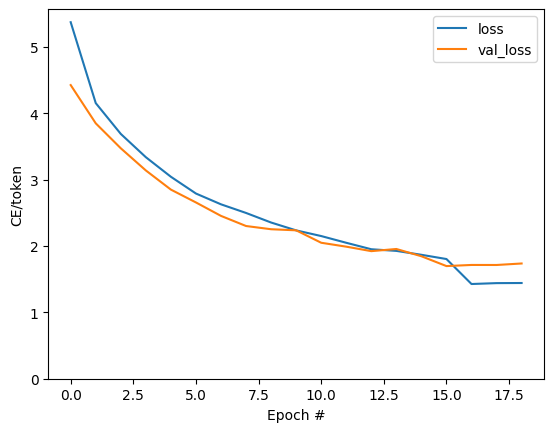

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

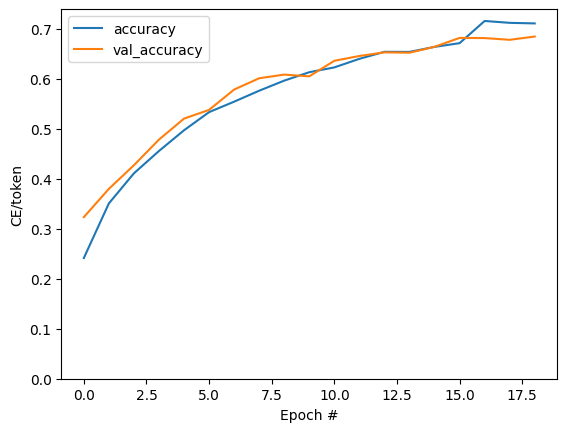

In [23]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [25]:
model.translate(['לאן אתה הולך?'])

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'where are you going ? '], dtype=object)>